# Environments

# Eval

In [5]:
"""
In this demo, we evaluate the performance of the
lofi bandit on a tabular dataset
"""
import os
import re
import jax
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
from datetime import datetime
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

from bandits import training as btrain
from bandits.agents.linear_bandit import LinearBandit
from bandits.agents.low_rank_filter_bandit import LowRankFilterBandit
from bandits.agents.neural_linear import NeuralLinearBandit
from bandits.agents.neural_greedy import NeuralGreedyBandit
from bandits.environments.mnist_env import MnistEnvironment

import lofi_tabular as experiment

In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 14

In [7]:
class MLP(nn.Module):
    num_arms: int

    @nn.compact
    def __call__(self, x):
        # x = nn.Dense(50)(x)
        # x = nn.relu(x)
        x = nn.Dense(500, name="last_layer")(x)
        x = nn.relu(x)
        x = nn.Dense(self.num_arms)(x)
        return x

In [8]:
ntrials = 1
npulls = 20
key = jax.random.PRNGKey(314)
key_env, key_train, key_eval = jax.random.split(key, 3)

# env = TabularEnvironment(key_env, ntrain=ntrain, name='statlog', intercept=False, path="../bandit-data")
env = MnistEnvironment(key, ntrain=500)
env_test = MnistEnvironment(key, ntrain=8000)

num_arms = env.labels_onehot.shape[-1]
model = MLP(num_arms)

In [9]:
optimisers = {}
results = {}

## LoFi: Fixed dynamics

In [7]:
name_agent = "lofi-fixed"
extra_params = {
    "memory_size": 10,
    "model": model,
    "dynamics_weights": 1.0,
    "dynamics_covariance": 0.0,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_lofi_fixed,
        LowRankFilterBandit,
        env,
        key_train,
        npulls,
        **extra_params,
    )

    
    return res["hist_train"]["rewards"].sum()

In [8]:
%%time
# try q=0, γ=1
pbounds = {
    "log_em_cov": [-15, -1],
    "log_init_cov": [-15, -1],
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   | log_em... | log_in... |
-------------------------------------------------
| 1         | 164.0     | -9.033    | -5.159    |
| 2         | 80.0      | -3.12     | -14.94    |
| 3         | 228.0     | -13.82    | -14.9     |
| 4         | 193.0     | -7.946    | -8.266    |
| 5         | 53.0      | -2.74     | -2.798    |
| 6         | 193.0     | -13.0     | -10.62    |
| 7         | 167.0     | -10.26    | -14.97    |
| 8         | 45.0      | -15.0     | -1.0      |
| 9         | 211.0     | -15.0     | -12.99    |
| 10        | 214.0     | -14.92    | -14.84    |
| 11        | 46.0      | -14.97    | -7.96     |
| 12        | 199.0     | -10.08    | -11.32    |
| 13        | 212.0     | -12.59    | -13.04    |
| 14        | 86.0      | -1.0      | -9.239    |
| 15        | 216.0     | -10.3     | -8.671    |
| 16        | 56.0      | -8.46     | -1.0      |
| 17        | 214.0     | -13.9     | -13.89    |
| 18        | 206.0     | -12.52    | -15.0     |


In [9]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_lofi_fixed,
    LowRankFilterBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params,
)

res = jax.tree_map(np.array, res)
results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 27.5 s, sys: 845 ms, total: 28.3 s
Wall time: 40.7 s


## Linear

In [10]:
name_agent = "linear"

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_linear,
        LinearBandit,
        env,
        key_train,
        npulls,
    )

    
    return res["hist_train"]["rewards"].sum()

In [11]:
%%time
pbounds = {
    "eta": [0, 10],
    "log_lambda": [-8, 0],
}

optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   |    eta    | log_la... |
-------------------------------------------------
| 1         | 48.0      | 4.262     | -2.377    |
| 2         | 45.0      | 8.486     | -7.964    |
| 3         | 45.0      | 0.8413    | -7.942    |
| 4         | 40.0      | 5.039     | -4.152    |
| 5         | 52.0      | 8.757     | -1.028    |
| 6         | 45.0      | 3.228     | -6.277    |
| 7         | 57.0      | 5.14      | -0.7948   |
| 8         | 64.0      | 6.432     | 0.0       |
| 9         | 92.0      | 0.7073    | 0.0       |
| 10        | 191.0     | 0.005823  | -1.728    |
| 11        | 83.0      | 0.0       | -2.84     |
| 12        | 94.0      | 0.1579    | -1.332    |
| 13        | 52.0      | 9.517     | -1.392    |
| 14        | 43.0      | 5.762     | -4.201    |
| 15        | 104.0     | 0.08202   | -1.822    |
| 16        | 104.0     | 0.08985   | -1.749    |
| 17        | 62.0      | 2.366     | -2.094    |
| 18        | 45.0      | 2.596     | -7.402    |


In [12]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_linear,
    LinearBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
)

results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 51.9 s, sys: 4.61 s, total: 56.5 s
Wall time: 10.3 s


## Neural linear

In [13]:
name_agent = "neural-linear"
extra_params = {
    "model": model,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_neural_linear,
        NeuralLinearBandit,
        env,
        key_train,
        npulls,
        **extra_params
    )
    
    return res["hist_train"]["rewards"].sum()

In [14]:
%%time
pbounds = {
    "eta": [0, 10],
    "log_lambda": [-8, 0],
    "log_lr": [-10, -2]
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   |    eta    | log_la... |  log_lr   |
-------------------------------------------------------------
| 1         | 45.0      | 4.262     | -2.377    | -3.211    |
| 2         | 53.0      | 0.04448   | -7.327    | -9.942    |
| 3         | 45.0      | 5.039     | -4.152    | -2.994    |
| 4         | 45.0      | 8.715     | -0.2811   | -2.535    |
| 5         | 45.0      | 0.375     | -6.947    | -4.983    |
| 6         | 40.0      | 2.44      | -8.0      | -10.0     |
| 7         | 45.0      | 5.03      | -4.264    | -4.832    |
| 8         | 57.0      | 9.86      | -1.025    | -7.315    |
| 9         | 49.0      | 9.911     | -1.267    | -7.7      |
| 10        | 46.0      | 9.907     | -0.8264   | -7.41     |
| 11        | 54.0      | 7.318     | -1.496    | -7.878    |
| 12        | 45.0      | 8.662     | -6.697    | -4.953    |
| 13        | 43.0      | 0.3076    | -2.579    | -5.038    |
| 14        | 45.0      | 3.857     | -6.982    | -6.741    |
| 15    

In [15]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_neural_linear,
    NeuralLinearBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params
)

results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 29.4 s, sys: 1.98 s, total: 31.4 s
Wall time: 9.09 s


## Neural Greedy (replay-buffer)

In [17]:
name_agent = "rsgd"
extra_params = {
    "model": model,
    "memory_size": 10,
    "epsilon": 0.1,
    "n_inner": 1.0,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_rsgd,
        NeuralGreedyBandit,
        env,
        key_train,
        npulls,
        **extra_params
    )
    
    return res["hist_train"]["rewards"].sum()

In [18]:
%%time
pbounds = {
    "log_lr": [-10, -2]
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | 147.0     | -6.59     |
| 2         | 79.0      | -4.377    |
| 3         | 65.0      | -3.211    |
| 4         | 195.0     | -9.964    |
| 5         | 195.0     | -9.327    |
| 6         | 214.0     | -8.678    |
| 7         | 183.0     | -7.882    |
| 8         | 209.0     | -8.44     |
| 9         | 184.0     | -8.822    |
| 10        | 95.0      | -4.826    |
| 11        | 195.0     | -9.327    |
| 12        | 61.0      | -2.0      |
| 13        | 170.0     | -7.3      |
| 14        | 130.0     | -5.789    |
| 15        | 190.0     | -9.644    |
| 16        | 181.0     | -7.602    |
| 17        | 205.0     | -8.568    |
| 18        | 183.0     | -8.183    |
| 19        | 109.0     | -5.336    |
| 20        | 146.0     | -6.96     |
CPU times: user 1min 22s, sys: 1min 35s, total: 2min 57s
Wall time: 47.7 s


In [19]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_rsgd,
    NeuralGreedyBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params
)

results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 3.09 s, sys: 373 ms, total: 3.47 s
Wall time: 2.69 s


## Plots

In [20]:
results.keys()

dict_keys(['lofi-fixed', 'linear', 'neural-linear', 'rsgd'])

In [24]:
name_mapping = {
    "lofi-fixed": "Neural-Lofi TS",
    "linear": "Linear TS",
    "neural-linear": "Neural-linear TS",
    "rsgd": "Neural-RB Greedy",
}

In [25]:
filename = "bandit-showdown-mem10.pkl"
path = os.path.join("output", "results", filename)

with open(path, "wb") as f:
    pickle.dump(results, f)

lofi-fixed - 6097.38±360.14
linear - 4587.38±72.49
neural-linear - 3508.50±322.13
rsgd - 5780.12±37.38


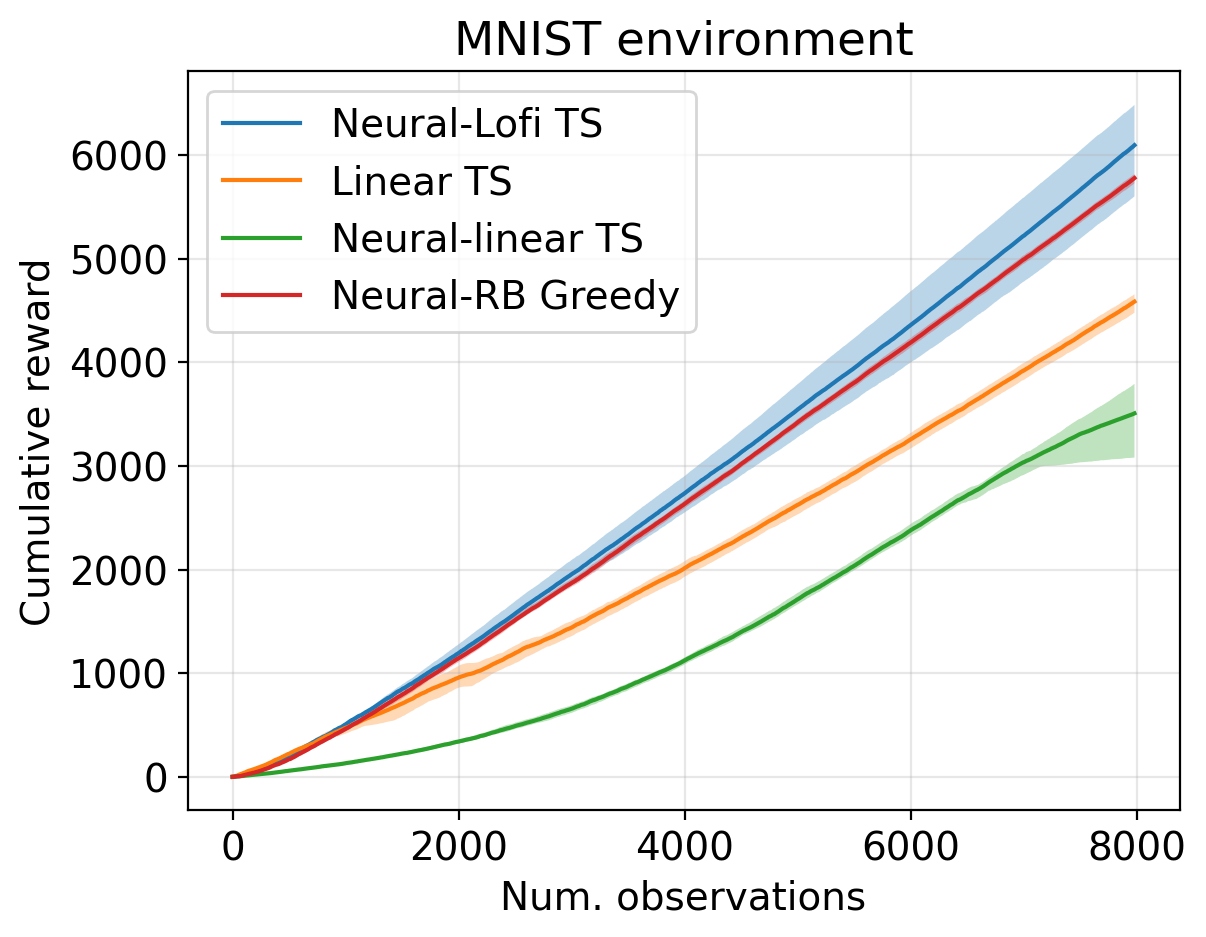

In [26]:
for name, res in results.items():
    label = name_mapping[name]
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()
    std_reward = rewards.sum(axis=1).std()

    rewards = pd.DataFrame(rewards).T.cumsum(axis=0)
    print(f"{name} - {mean_reward:0.2f}±{std_reward:0.2f}")

    nsteps = len(rewards)
    rmean = rewards.mean(axis=1)
    ubound = rewards.quantile(0.9, axis=1)
    lbound = rewards.quantile(0.1, axis=1)
    
    plt.fill_between(rewards.index, lbound, ubound, alpha=0.3)
    plt.plot(rewards.index, rmean, label=label)
    
# plt.plot([0, nsteps], [0, nsteps], c="tab:gray", linewidth=1, linestyle="--", label="oracle")
plt.legend()
plt.grid(alpha=0.3)
plt.ylabel("Cumulative reward")
plt.xlabel("Num. observations")
plt.title("MNIST environment")
plt.savefig("./output/figures/mnist-bandits-memory10.pdf")

---

# LoFi: varying buffer

In [10]:
class MLP(nn.Module):
    num_arms: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = nn.elu(x)
        x = nn.Dense(200)(x)
        x = nn.elu(x)
        x = nn.Dense(200)(x)
        x = nn.elu(x)
        x = nn.Dense(200, name="last_layer")(x)
        x = nn.elu(x)
        x = nn.Dense(self.num_arms)(x)
        return x

In [11]:
model = MLP(num_arms)

In [12]:
from loguru import logger

logger.add("lofi-bandit-mnist-new4.log")

1

In [13]:
list_memory = range(1, 31)
len(list_memory)

30

In [ ]:
# %%time

MLPsults = {}
n_trials = 3 * 8

extra_params = {
    # "memory_size": 10,
    "model": model,
    "dynamics_weights": 1.0,
    "dynamics_covariance": 0.0,

}

for memory_size in list_memory:
    name_agent = f"lofi-fixed-m{memory_size}"
    print(f"Evaluating {name_agent}")
    
    params = {
        "log_em_cov":  -10.0,
        "log_init_cov": -8.0,
    }
    
    res = experiment.warmup_and_run(
        params, 
        experiment.transform_hparams_lofi_fixed,
        LowRankFilterBandit,
        env_test,
        key_eval,
        npulls,
        n_trials=n_trials,
        **extra_params,
        memory_size=memory_size,
    )

    res = jax.tree_map(np.array, res)
    results[name_agent] = res
    
    
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()
    std_reward = rewards.sum(axis=1).std()
    
    logger.info(f"{name_agent} - {mean_reward:0.2f}±{std_reward:0.2f}")

Evaluating lofi-fixed-m1


2023-05-21 09:08:33.110 | INFO     | __main__:<module>:43 - lofi-fixed-m1 - 6170.54±45.29


Evaluating lofi-fixed-m2


2023-05-21 09:12:59.709 | INFO     | __main__:<module>:43 - lofi-fixed-m2 - 6153.88±80.33


Evaluating lofi-fixed-m3


2023-05-21 09:17:39.759 | INFO     | __main__:<module>:43 - lofi-fixed-m3 - 6191.00±65.86


Evaluating lofi-fixed-m4


2023-05-21 09:22:14.948 | INFO     | __main__:<module>:43 - lofi-fixed-m4 - 6219.71±49.50


Evaluating lofi-fixed-m5


2023-05-21 09:27:08.376 | INFO     | __main__:<module>:43 - lofi-fixed-m5 - 6201.67±91.14


Evaluating lofi-fixed-m6


2023-05-21 09:32:04.401 | INFO     | __main__:<module>:43 - lofi-fixed-m6 - 6215.12±102.80


Evaluating lofi-fixed-m7


2023-05-21 09:36:52.334 | INFO     | __main__:<module>:43 - lofi-fixed-m7 - 6252.58±89.54


Evaluating lofi-fixed-m8


2023-05-21 09:38:59.215 | INFO     | __main__:<module>:43 - lofi-fixed-m8 - 6225.38±184.15


Evaluating lofi-fixed-m9


2023-05-21 09:41:58.355 | INFO     | __main__:<module>:43 - lofi-fixed-m9 - 6229.08±146.84


Evaluating lofi-fixed-m10


2023-05-21 09:44:58.672 | INFO     | __main__:<module>:43 - lofi-fixed-m10 - 6276.46±139.68


Evaluating lofi-fixed-m11


2023-05-21 09:48:04.400 | INFO     | __main__:<module>:43 - lofi-fixed-m11 - 6288.67±113.13


Evaluating lofi-fixed-m12


2023-05-21 09:51:05.771 | INFO     | __main__:<module>:43 - lofi-fixed-m12 - 6329.17±97.87


Evaluating lofi-fixed-m13


2023-05-21 09:53:59.256 | INFO     | __main__:<module>:43 - lofi-fixed-m13 - 6296.75±148.22


Evaluating lofi-fixed-m14


2023-05-21 09:56:53.566 | INFO     | __main__:<module>:43 - lofi-fixed-m14 - 6287.62±148.16


Evaluating lofi-fixed-m15


2023-05-21 09:59:46.541 | INFO     | __main__:<module>:43 - lofi-fixed-m15 - 6308.33±145.55


Evaluating lofi-fixed-m16


2023-05-21 10:02:48.363 | INFO     | __main__:<module>:43 - lofi-fixed-m16 - 6346.38±76.45


Evaluating lofi-fixed-m17


2023-05-21 10:06:52.749 | INFO     | __main__:<module>:43 - lofi-fixed-m17 - 6302.92±155.48


Evaluating lofi-fixed-m18


2023-05-21 10:10:48.540 | INFO     | __main__:<module>:43 - lofi-fixed-m18 - 6317.17±146.35


Evaluating lofi-fixed-m19


2023-05-21 10:14:45.163 | INFO     | __main__:<module>:43 - lofi-fixed-m19 - 6305.46±139.25


Evaluating lofi-fixed-m20


tcmalloc: large alloc 1104216064 bytes == 0x55575d7ac000 @  0x7f0a36d23680 0x7f0a36d44824 0x7f0a26b0fa05 0x7f0a26b0fff0 0x7f0a26b58728 0x7f0a26b5a877 0x7f0a26beec70 0x5555a13203e7 0x5555a131ce55 0x5555a133490d 0x5555a1327513 0x5555a1325f54 0x5555a131cbe8 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a131afaf 0x5555a132903f 0x5555a13cb684 0x5555a1401653 0x5555a131ce55 0x5555a1320fd2 0x5555a1334109 0x5555a14081a5 0x5555a1321cfb
2023-05-21 10:18:34.976 | INFO     | __main__:<module>:43 - lofi-fixed-m20 - 6350.42±118.35


Evaluating lofi-fixed-m21


2023-05-21 10:22:25.779 | INFO     | __main__:<module>:43 - lofi-fixed-m21 - 6313.54±132.50


Evaluating lofi-fixed-m22


tcmalloc: large alloc 1214636032 bytes == 0x55575d7ac000 @  0x7f0a36d23680 0x7f0a36d44824 0x7f0a26b0fa05 0x7f0a26b0fff0 0x7f0a26b58728 0x7f0a26b5a877 0x7f0a26beec70 0x5555a13203e7 0x5555a131ce55 0x5555a133490d 0x5555a1327513 0x5555a1325f54 0x5555a131cbe8 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a131afaf 0x5555a132903f 0x5555a13cb684 0x5555a1401653 0x5555a131ce55 0x5555a1320fd2 0x5555a1334109 0x5555a14081a5 0x5555a1321cfb
2023-05-21 10:26:21.204 | INFO     | __main__:<module>:43 - lofi-fixed-m22 - 6327.21±130.44


Evaluating lofi-fixed-m23


2023-05-21 10:30:15.869 | INFO     | __main__:<module>:43 - lofi-fixed-m23 - 6306.83±138.96


Evaluating lofi-fixed-m24


2023-05-21 10:34:20.113 | INFO     | __main__:<module>:43 - lofi-fixed-m24 - 6313.79±167.30


Evaluating lofi-fixed-m25


tcmalloc: large alloc 1380270080 bytes == 0x5557c6c9c000 @  0x7f0a36d23680 0x7f0a36d44824 0x7f0a26b0fa05 0x7f0a26b0fff0 0x7f0a26b58728 0x7f0a26b5a877 0x7f0a26beec70 0x5555a13203e7 0x5555a131ce55 0x5555a133490d 0x5555a1327513 0x5555a1325f54 0x5555a131cbe8 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a1318724 0x5555a132903f 0x5555a131afaf 0x5555a132903f 0x5555a13cb684 0x5555a1401653 0x5555a131ce55 0x5555a1320fd2 0x5555a1334109 0x5555a14081a5 0x5555a1321cfb
2023-05-21 10:39:24.641 | INFO     | __main__:<module>:43 - lofi-fixed-m25 - 6297.67±166.82


Evaluating lofi-fixed-m26


lofi-fixed-m1 - 6170.54±45.29
lofi-fixed-m2 - 6153.88±80.33
lofi-fixed-m3 - 6191.00±65.86
lofi-fixed-m4 - 6219.71±49.50
lofi-fixed-m5 - 6201.67±91.14
lofi-fixed-m6 - 6215.12±102.80
lofi-fixed-m7 - 6252.58±89.54
lofi-fixed-m8 - 6225.38±184.15
lofi-fixed-m9 - 6229.08±146.84
lofi-fixed-m10 - 6276.46±139.68
lofi-fixed-m11 - 6288.67±113.13
lofi-fixed-m12 - 6329.17±97.87
lofi-fixed-m13 - 6296.75±148.22
lofi-fixed-m14 - 6287.62±148.16
lofi-fixed-m15 - 6308.33±145.55
lofi-fixed-m16 - 6346.38±76.45
lofi-fixed-m17 - 6302.92±155.48
lofi-fixed-m18 - 6317.17±146.35
lofi-fixed-m19 - 6305.46±139.25
lofi-fixed-m20 - 6350.42±118.35
lofi-fixed-m21 - 6313.54±132.50
lofi-fixed-m22 - 6327.21±130.44
lofi-fixed-m23 - 6306.83±138.96
lofi-fixed-m24 - 6313.79±167.30
lofi-fixed-m25 - 6297.67±166.82
lofi-fixed-m26 - 6344.96±116.13
lofi-fixed-m27 - 6304.08±157.57
lofi-fixed-m28 - 6311.92±154.53
lofi-fixed-m29 - 6320.25±148.61
lofi-fixed-m30 - 6330.92±154.42


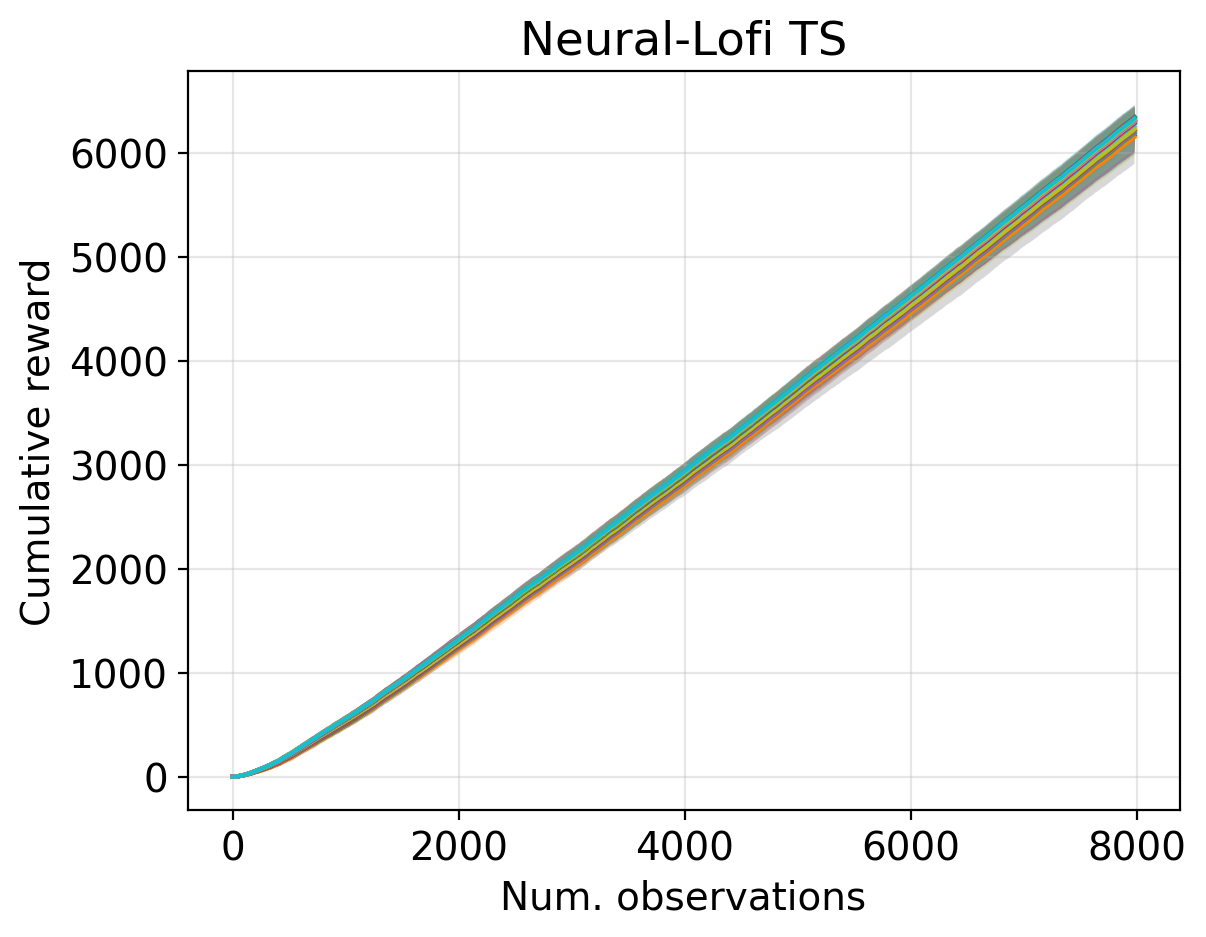

In [16]:
final_rewards = {}
for name, res in results.items():
    # label = name_mapping[name]
    memory = int(re.findall(r"[0-9]+", name)[0])
    label = f"{memory}"
    
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()
    std_reward = rewards.sum(axis=1).std()

    rewards = pd.DataFrame(rewards).T.cumsum(axis=0)
    print(f"{name} - {mean_reward:0.2f}±{std_reward:0.2f}")

    nsteps = len(rewards)
    rmean = rewards.mean(axis=1)
    ubound = rewards.quantile(0.9, axis=1)
    lbound = rewards.quantile(0.1, axis=1)
    
    plt.fill_between(rewards.index, lbound, ubound, alpha=0.3)
    plt.plot(rewards.index, rmean, label=label)
    
    final_reward = res["hist_train"]["rewards"].sum(axis=1)
    final_rewards[name] = final_reward
    
# plt.plot([0, nsteps], [0, nsteps], c="tab:gray", linewidth=1, linestyle="--", label="oracle")
# plt.legend(title="Memory")
plt.grid(alpha=0.3)
plt.ylabel("Cumulative reward")
plt.xlabel("Num. observations")
plt.title("Neural-Lofi TS") # MNIST
plt.savefig("./output/figures/mnist-bandits-lofi.pdf")
final_rewards = pd.DataFrame(final_rewards)

In [17]:
new_cols = [re.findall(r"[0-9]+", name)[0] for name in final_rewards.columns]
final_rewards.columns = new_cols

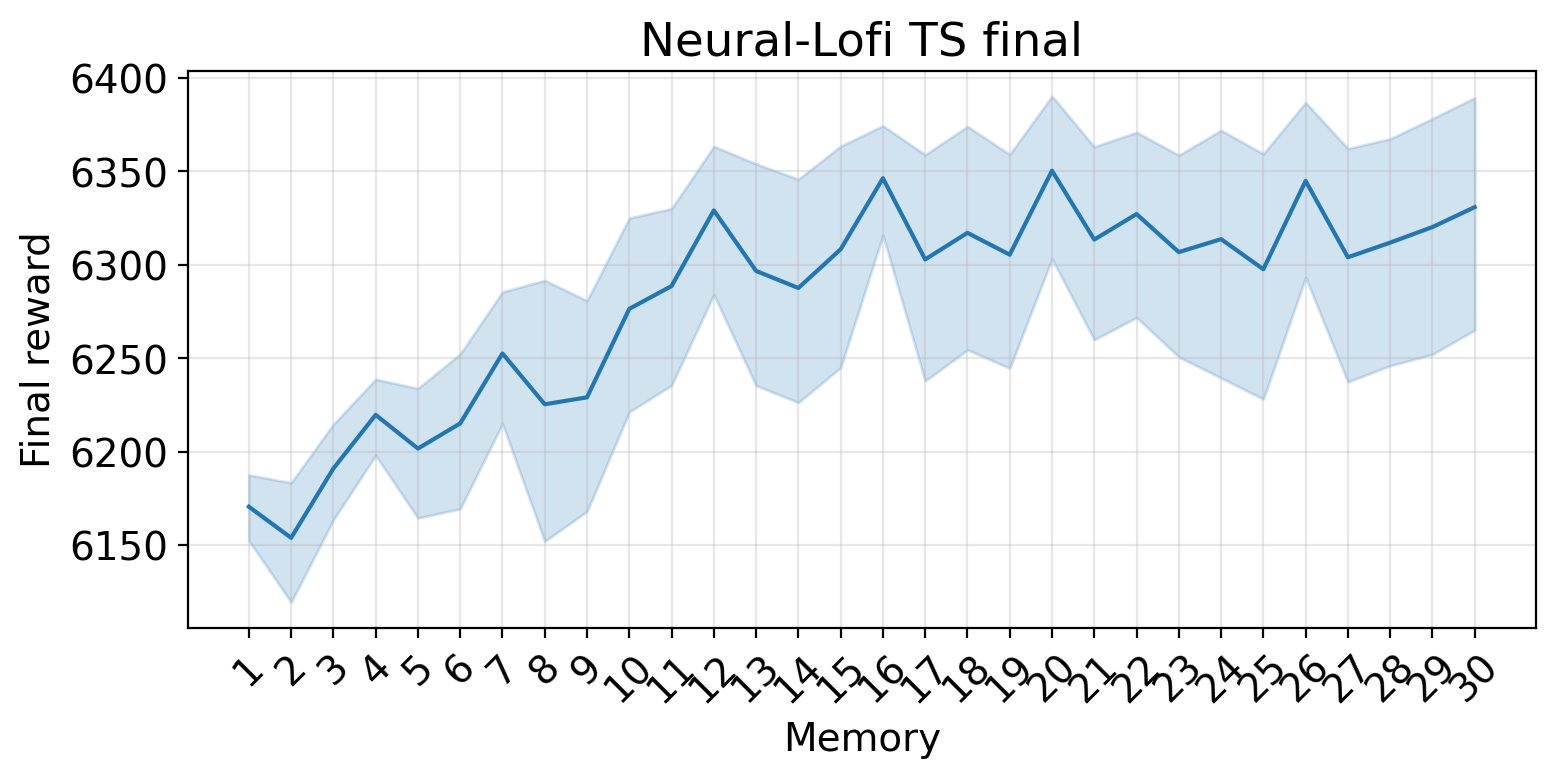

In [29]:
fig, ax = plt.subplots(figsize=(8, 4.0))
sns.lineplot(
    x="variable",
    y="value",
    data=final_rewards.melt()
)
plt.xlabel("Memory")
plt.ylabel("Final reward")
plt.grid(alpha=0.3)
plt.title("Neural-Lofi TS final") # MNIST
plt.tight_layout()
plt.savefig("./output/figures/mnist-bandits-lofi-final-lineplot.pdf")
plt.xticks(rotation=45);